## Lecture - Convolutional Neural Networks in Keras
Romen Samuel Wabina

This tutorial will explain how to build an X-ray image classification model to predict whether an X-ray scan shows presence of pneumonia. See [Source](https://keras.io/examples/vision/xray_classification_with_tpus/).

In [3]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

c:\Users\Renan\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Number of replicas: 1


We need a Google Cloud link to our data to load the data using a TPU. Below, we define key configuration parameters we'll use in this example. To run on TPU, this example must be on Colab with the TPU runtime selected.

The Chest X-ray data we are using from Cell divides the data into training and test files. Let's first load in the training TFRecords.

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 25 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

train_images = tf.data.TFRecordDataset("gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec")
train_paths  = tf.data.TFRecordDataset("gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec")

ds = tf.data.Dataset.zip((train_images, train_paths))

In [5]:
COUNT_NORMAL = len(
    [
        filename
        for filename in train_paths
        if "NORMAL" in filename.numpy().decode("utf-8")
    ]
)
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len(
    [
        filename
        for filename in train_paths
        if "PNEUMONIA" in filename.numpy().decode("utf-8")
    ]
)
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1349
Pneumonia images count in training set: 3883


Notice that there are way more images that are classified as pneumonia than normal. This shows that we have an imbalance in our data. We will correct for this imbalance later on in our notebook. We want to map each filename to the corresponding (image, label) pair. The following methods will help us do that. As we only have two labels, we will encode the label so that 1 or True indicates pneumonia and 0 or False indicates normal.

In [6]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, "/")
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    label = get_label(path)
    # load the raw data from the file as a string
    img = decode_img(image)
    return img, label


ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [7]:
ds = ds.shuffle(10000)
train_ds = ds.take(4200)
val_ds = ds.skip(4200)

In [8]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [9]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

### Visualize the dataset
First, let's use buffered prefetching so we can yield data from disk without having I/O become blocking. Please note that large image datasets should not be cached in memory. We do it here because the dataset is not very large and we want to train on TPU.

In [11]:
def prepare_for_training(ds, cache=True):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [12]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [13]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

As the method takes in NumPy arrays as its parameters, call the numpy function on the batches to return the tensor in NumPy array form.

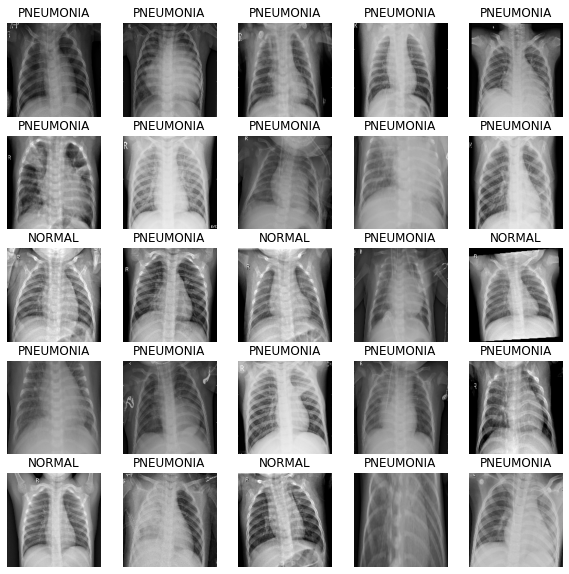

In [14]:
show_batch(image_batch.numpy(), label_batch.numpy())

### Build the CNN
To make our model more modular and easier to understand, let's define some blocks. As we're building a convolution neural network, we'll create a convolution block and a dense layer block. The architecture for this CNN has been inspired by this article.

In [15]:
from tensorflow import keras
from keras import layers


def conv_block(filters, inputs):
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(inputs)
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.MaxPool2D()(x)

    return outputs

def dense_block(units, dropout_rate, inputs):
    x = layers.Dense(units, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dropout(dropout_rate)(x)

    return outputs

The following method will define the function to build our model for us.

The images originally have values that range from [0, 255]. CNNs work better with smaller numbers so we will scale this down for our input.

The Dropout layers are important, as they reduce the likelikhood of the model overfitting. We want to end the model with a Dense layer with one node, as this will be the binary output that determines if an X-ray shows presence of pneumonia.

In [16]:
def build_model():
    inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)

    x = conv_block(32, x)
    x = conv_block(64, x)

    x = conv_block(128, x)
    x = layers.Dropout(0.2)(x)

    x = conv_block(256, x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = dense_block(512, 0.7, x)
    x = dense_block(128, 0.5, x)
    x = dense_block(64, 0.3, x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [17]:
initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 1.05724
Weight for class 0: 1.94
Weight for class 1: 0.67


In [18]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, 
                                                     restore_best_weights = True)

In [19]:
initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, 
                                                             decay_steps = 100000, 
                                                             decay_rate = 0.96, 
                                                             staircase = True)

### Fit the model
For our metrics, we want to include precision and recall as they will provide use with a more informed picture of how good our model is. Accuracy tells us what fraction of the labels is correct. Since our data is not balanced, accuracy might give a skewed sense of a good model (i.e. a model that always predicts PNEUMONIA will be 74% accurate but is not a good model).

Precision is the number of true positives (TP) over the sum of TP and false positives (FP). It shows what fraction of labeled positives are actually correct.

Recall is the number of TP over the sum of TP and false negatves (FN). It shows what fraction of actual positives are correct.

Since there are only two possible labels for the image, we will be using the binary crossentropy loss. When we fit the model, remember to specify the class weights, which we defined earlier. Because we are using a TPU, training will be quick - less than 2 minutes.

In [24]:
with strategy.scope():
    model = build_model()

    METRICS = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name = "precision"),
        tf.keras.metrics.Recall(name = "recall"),
    ]
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss = "binary_crossentropy",
        metrics = METRICS,
    )

history = model.fit(
    train_ds,
    epochs = 2,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb],)

Epoch 1/2
168/168 [==============================] - 261s 1s/step - loss: 0.3990 - binary_accuracy: 0.8231 - precision: 0.9331 - recall: 0.8200 - val_loss: 4.6973 - val_binary_accuracy: 0.3479 - val_precision: 1.0000 - val_recall: 0.1438
Epoch 2/2
168/168 [==============================] - 255s 2s/step - loss: 0.2502 - binary_accuracy: 0.9024 - precision: 0.9652 - recall: 0.9007 - val_loss: 1.0018 - val_binary_accuracy: 0.7888 - val_precision: 0.7851 - val_recall: 0.9949


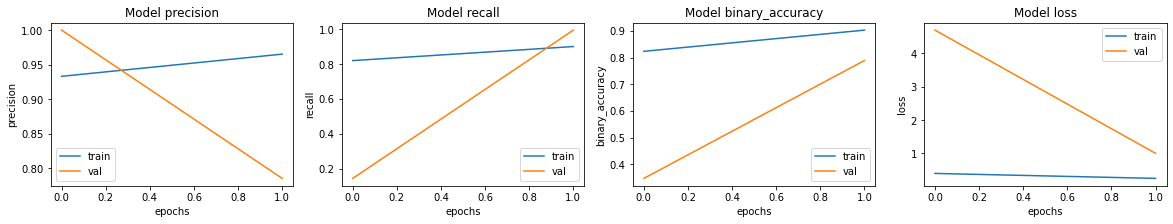

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [32]:
import h5py 


node_train = h5py.File('../data/train.h5', 'r')
X_train, y_train = np.array(node_train.get('X')), np.array(node_train.get('y'))
node_train.close()

node_val = h5py.File('../data/val.h5', 'r')
X_val, y_val = np.array(node_val.get('X')), np.array(node_val.get('y'))
node_val.close()

node_test = h5py.File('../data/test.h5', 'r')
X_test, y_test = np.array(node_test.get('X')), np.array(node_test.get('y'))
node_test.close()


In [52]:
from keras.applications import VGG16 
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint


height, width, depth = 50, 50, 3
input_tensor = Input(shape=(height, width, depth))

pretrain = VGG16(weights = "imagenet", include_top = False, input_tensor = input_tensor)

x = pretrain.output

model = Model(inputs=pretrain.input, outputs = x)
model.compile(loss = "categorical_crossentropy", 
              optimizer = Adam(lr = 0.001), 
              metrics = ["accuracy"])

# x = Flatten()(x)
# x = Dense(64, use_bias = False)(x)
# x = Dropout(0.25)
              
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

c:\Users\Renan\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [56]:
es = EarlyStopping(monitor = 'val_loss',
                   mode = 'min',
                   patience = 5,
                   verbose = 1)

                   
mc = ModelCheckpoint(filepath = 'mymodel.h5', 
                     monitor = 'val_loss',
                     mode = 'min', 
                     verbose = 1,
                     save_best_only = True)

In [21]:
history = model.fit(x = X_train,
                    y = y_train,
                    epochs = 500,
                    validation_data = (X_val, y_val),
                    callbacks = [es, mc])